In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import torch
#x1 = torch.rand(1,4)
x1 = torch.tensor([[0.5,0.5,-0.5]]) 
print('x1=',x1)
#x2 = torch.rand(1,4)
x2 = torch.tensor([[0.5,0.5,-0.5]]) 
print('x2=',x2)

x1= tensor([[ 0.5000,  0.5000, -0.5000]])
x2= tensor([[ 0.5000,  0.5000, -0.5000]])


In [ ]:
import sklearn
import tensorflow as tf

x = x1+x2
print('x=',x)
sigmoid = tf.math.sigmoid(x)
print('sigmoid=',sigmoid)
multi = tf.math.multiply(sigmoid,x2)
print('multi=',multi)
add = multi + x1
print('add: ',add)



x= tensor([[ 1.,  1., -1.]])
sigmoid= tf.Tensor([[0.7310586  0.7310586  0.26894143]], shape=(1, 3), dtype=float32)
multi= tf.Tensor([[ 0.3655293   0.3655293  -0.13447072]], shape=(1, 3), dtype=float32)
add:  tf.Tensor([[ 0.8655293  0.8655293 -0.6344707]], shape=(1, 3), dtype=float32)


In [ ]:
%cd '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/'
!ls

/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR
CrossValidationScore.py		  Predictions.py
cv_split.pickle			  predict.py
data				  __pycache__
EDA.ipynb			  README.md
initial_test_b3_fold3_clahe	  split_folds.ipynb
logs				  submit
MNIST				  submit_initial_test_b3.csv
model_concate_10_no_epoch.txt	  submit_oanh_initial_test_b3.csv
model_concate_15epoch_weight.txt  submit_vessel_initial_test_b3.csv
model_concate_19epoch.txt	  train_1cycle.py
model_concate_20epoch.txt	  train_all_folds_args.sh
model_concate_5_no_epoch.txt	  train_all_folds.sh
model_concate_6epoch.txt	  train.py
model_concate_epoch_20.txt	  utils.py
odir_submit.py			  Visualization.ipynb


In [ ]:
!pip install catalyst==20.2.4
!pip install tqdm==4.33
!pip install efficientnet_pytorch
!pip install pytorch_toolbelt

In [ ]:
from sklearn import svm
from keras.callbacks import CSVLogger
from keras.callbacks import LambdaCallback
from utils import *
import pandas as pd
import sys
import os
import cv2
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import torch
import collections
from pytorch_toolbelt.inference import tta
from catalyst.dl.callbacks import InferCallback
from catalyst.dl.runner import SupervisedRunner
from torch.nn.functional import softmax
from catalyst.dl.callbacks import EarlyStoppingCallback, AccuracyCallback, F1ScoreCallback, ConfusionMatrixCallback, MixupCallback
from catalyst.contrib.nn.schedulers import OneCycleLR, ReduceLROnPlateau, StepLR, MultiStepLR
from torchvision import transforms
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary
import pickle
import time
import copy

Using TensorFlow backend.
alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.


In [ ]:
data = pd.read_csv(
    '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/data/splited_train.csv')
splits = pickle.load(open(
    '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/cv_split.pickle', 'rb'))
labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
image_size = 240
fold_idx = 3
batch_size = 1
lr = 3e-6

In [ ]:
train_path1 = '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/data/clahe-train/'
valid_path1 = '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/data/clahe-train/'

train_dataset1 = EyeDataset(dataset_path=train_path1,
                           labels=data.loc[splits['train_idx'][fold_idx],labels].values,
                           ids=data.loc[splits['train_idx'][fold_idx], 'id'].values,
                           albumentations_tr=aug_train_heavy(image_size))

train_loader1 = DataLoader(train_dataset1,
                          num_workers=8,
                          pin_memory=False,
                          batch_size=batch_size,
                          shuffle=False)


logdir = '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/logs/clahe_no_val_from5_fold3/'
modelA = prepare_model('efficientnet-b3', 8)
modelA.cuda()
modelA.load_state_dict(torch.load(os.path.join(
    logdir, '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/logs/clahe_no_val_from5_fold3/checkpoints/best.pth'))['model_state_dict'])
modelA.eval()

Will load efficientnet-b3 with 8 classes


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [ ]:
train_path2 = '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/data/training-dataset/'
valid_path2 = '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/data/training-dataset/'

train_dataset2 = EyeDataset(dataset_path=train_path2,
                           labels=data.loc[splits['train_idx'][fold_idx], labels].values,
                           ids=data.loc[splits['train_idx'][fold_idx], 'id'].values,
                           albumentations_tr=aug_train_heavy(image_size))

train_loader2 = DataLoader(train_dataset2,
                          num_workers=8,
                          pin_memory=False,
                          batch_size=batch_size,
                          shuffle=False)

logdir = '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/logs/initial_test_b3_fold3_vessel/'
modelB = prepare_model('efficientnet-b3', 8)
modelB.cuda()
modelB.load_state_dict(torch.load(os.path.join(
    logdir, '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/logs/initial_test_b3_fold3_vessel/checkpoints/best.pth'))['model_state_dict'])
modelB.eval()

In [ ]:
for i1 in train_loader1:
  input1,target1 = i1
  #print(input1)
  #print(target1)
  print(i1)
  input1 = input1.cuda()
  break

[tensor([[[[-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          ...,
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665]],

         [[-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          ...,
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-1.9832, -1.9832, -1.9832,  ..., -1.9832, -1.9832, -1.9832]],

         [[-1.7522, -1.7522, -1.7522,  ..., -1.7522, -1.7522, -1.7522],
          [-1.7522, -1.7522, 

In [ ]:
for i2 in train_loader2:
  input2,target2 = i2
  #print(input2)
  #print(target2)
  input2 = input2.cuda()
  print(i2)
  break  

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, 

In [ ]:
import sklearn
class NeuralNet(nn.Module):
    def __init__(self, modelA, modelB, nb_classes=8):
        super(NeuralNet, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.drop = nn.Dropout(0.3)
        #self.out1 = nn.Linear(3072, 1536)
        self.out2 = nn.Linear(1536, 8)
        self.modelA.fc = nn.Identity()
        self.modelB.fc = nn.Identity()

    def forward(self, x1, x2):
        x1 = self.modelA.extract_features(x1)
        x2 = self.modelB.extract_features(x2)
        
        x1 = nn.AdaptiveAvgPool2d((1, 1))(x1)
        #print('x1: ',x1)
        x2 = nn.AdaptiveAvgPool2d((1, 1))(x2)
        #print('x2: ',x2)
        x1 = x1.view(1,1536)
        x1 = torch.Tensor.cpu(x1).detach().numpy()
        #print(type(x1))
        x2 = x2.view(1,1536)
        x2 = torch.Tensor.cpu(x2).detach().numpy()
        #print(type(x2))
        x1_norm = sklearn.preprocessing.normalize(x1, norm="l1")
        #print(x1_norm)
        x2_norm = sklearn.preprocessing.normalize(x2, norm="l1")
        #print(x2_norm)
        #print(type(x1))
        #print(type(x2))
        x = x1+x2       
        #print(x.shape)
        sigmoid = tf.math.sigmoid(x)
        multi = tf.math.multiply(sigmoid,x2)
        add = multi + x1
        #print('type add: ',type(add))
        add = add.numpy()
        #print('type add after: ',type(add))
        x = torch.from_numpy(add)
        #print('type: ',type(x))
        x = self.drop(x)
        x = x.flatten()
        #data = torch.Tensor.cpu(x).detach().numpy()
        #data = torch.from_numpy(data)
        #print(x.shape)
        x = self.out2(x)
        #print(x.shape)

        return x,x1,x2

In [ ]:
probabilities = []

x_model = NeuralNet(modelA, modelB)
y,visual_x1,visual_x2 = x_model(input1,input2)
print(y)
print(type(y))
y = torch.Tensor.cpu(y).detach().numpy()
print(y)
print(type(y))
probabilities = softmax(torch.from_numpy(y),dim=0).numpy()
print(probabilities)

tensor([ 0.3120,  0.4491, -0.0452, -0.5922, -0.9977, -0.2127, -0.5267, -0.1637],
       grad_fn=<AddBackward0>)
<class 'torch.Tensor'>
[ 0.31204784  0.4491124  -0.04523792 -0.59219897 -0.9976879  -0.21273911
 -0.52671283 -0.16373125]
<class 'numpy.ndarray'>
[0.19355309 0.22198647 0.13540444 0.07835933 0.05223832 0.11452176
 0.08366254 0.12027404]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



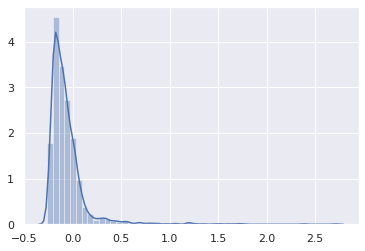

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.distplot(visual_x1)

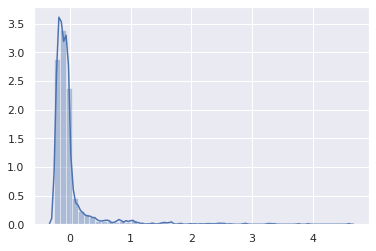

In [ ]:
sns.distplot(visual_x2)

In [ ]:
x_model = NeuralNet(modelA, modelB)
x_model.load_state_dict(torch.load(os.path.join(
        '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/logs/concate/model_concate_epoch5.pth')))
x_model.eval()

In [ ]:
optimizer = torch.optim.Adam(x_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=5)

dem = 0
loss_log = []
PATH_SAVE = '/content/gdrive/My Drive/Colab Notebooks/odir-ivashnyov/ODIR/logs/concate_2model_clahe_vessel_forgetgate_lr/'
if not os.path.exists(PATH_SAVE):
       os.makedirs(PATH_SAVE)
for epoch in range(30):
  print('====Epoch ',epoch,": ")
  for i1, i2 in zip(enumerate(train_loader1),enumerate(train_loader2)):
    dem = dem + 1
    stt1, data1 = i1
    input1,target1 = data1

    stt2, data2 = i2
    input2,target2 = data2

    optimizer.zero_grad()
    input1 = input1.cuda()
    input2 = input2.cuda()

    outputs = x_model(input1,input2)
    outputs = outputs.view(1,8)

    loss = criterion(outputs, target1)
    loss.backward()
    optimizer.step()

    if dem%1000==0:
        print('so luong: ',dem,'/',len(train_loader1))
  loss_log.append(loss)
  print(loss)
  dem = 0
  if(epoch>=10):
    torch.save(x_model.state_dict(), PATH_SAVE + 'concate_2model_clahe_vessel_forgetgate_lr'+str(epoch)+'.pth')

with open(PATH_SAVE+"concate_2model_clahe_vessel_forgetgate_lr.txt", "w") as output:
    output.write(str(loss_log))

====Epoch  0 : 
so luong:  1000 / 5220
so luong:  2000 / 5220
so luong:  3000 / 5220
so luong:  4000 / 5220
so luong:  5000 / 5220
tensor(0.5131, grad_fn=<NllLossBackward>)
====Epoch  1 : 
so luong:  1000 / 5220
so luong:  2000 / 5220
so luong:  3000 / 5220
so luong:  4000 / 5220
so luong:  5000 / 5220
tensor(0.8789, grad_fn=<NllLossBackward>)
====Epoch  2 : 
so luong:  1000 / 5220
so luong:  2000 / 5220
so luong:  3000 / 5220
so luong:  4000 / 5220
so luong:  5000 / 5220
tensor(0.3737, grad_fn=<NllLossBackward>)
====Epoch  3 : 
so luong:  1000 / 5220
so luong:  2000 / 5220
so luong:  3000 / 5220
so luong:  4000 / 5220
so luong:  5000 / 5220
tensor(0.6426, grad_fn=<NllLossBackward>)
====Epoch  4 : 
so luong:  1000 / 5220
so luong:  2000 / 5220
so luong:  3000 / 5220
so luong:  4000 / 5220
so luong:  5000 / 5220
tensor(2.0841, grad_fn=<NllLossBackward>)
====Epoch  5 : 
so luong:  1000 / 5220
so luong:  2000 / 5220
so luong:  3000 / 5220
so luong:  4000 / 5220
so luong:  5000 / 5220
tens